In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt
import glob
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.solver import build_lr_scheduler
from vis import *
from dataset_bjtu import *

import torch
from detectron2.engine import DefaultTrainer

print(torch.cuda.is_available())
print(torch.cuda.get_device_capability())
os.environ["CUDA_VISIBLE_DEVICES"] = "1,"

register_coco_instances("bjtu_train_washed", {}, "BJTU_washed/train.json", ".")
register_coco_instances("bjtu_test_washed", {}, "BJTU_washed/test.json", ".")

True
(9, 0)


# 定义Trainer和Aug

In [2]:
from detectron2.data import transforms as T
class MyColorAugmentation(T.Augmentation):
    def get_transform(self, image):
        r = np.random.rand(2)
        return T.ColorTransform(lambda x: x * r[0] + r[1] * 10)

In [3]:
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper  # the default mapper
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    os.makedirs(cfg.EVAL_DIR, exist_ok=True)
    return COCOEvaluator(dataset_name, cfg, False, cfg.EVAL_DIR)

def build_text_detect_train_aug(cfg):
    
    augs = [
        T.RandomRotation(angle=[-60, 60], expand=False),
        T.RandomCrop("relative_range", [0.7, 0.7]),
        # T.ResizeShortestEdge(
        #     cfg.INPUT.MIN_SIZE_TRAIN,
        #     cfg.INPUT.MAX_SIZE_TRAIN,
        #     cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING,
        # )
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomLighting(0.7),    
    ]
    # if cfg.INPUT.CROP.ENABLED:
    #     augs.append(
    #         T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
    #     )
    # augs.append(T.RandomFlip()) # not useful for text detection
    return augs

def build_text_detect_val_aug(cfg):
    return [
        T.Resize((800,600)),
    ]


class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        os.makedirs(cfg.EVAL_DIR, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, False, cfg.EVAL_DIR)
    
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)

    # @classmethod
    # def build_train_loader(cls, cfg):

    #     mapper = DatasetMapper(
    #             cfg, is_train=True, augmentations=build_text_detect_train_aug(cfg)
    #         )

    #     return build_detection_train_loader(cfg, mapper=mapper)
    
    # @classmethod
    # def build_test_loader(cls, cfg, dataset_name):
    #     return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, is_train=False, augmentations=build_text_detect_val_aug(cfg)))

    # @classmethod
    # def build_lr_scheduler(cls, cfg, optimizer):
    #     """
    #     It now calls :func:`detectron2.solver.build_lr_scheduler`.
    #     Overwrite it if you'd like a different scheduler.
    #     """
    #     return build_lr_scheduler(cfg, optimizer)



# 修改cfg

In [4]:
cfg = get_cfg()
cfg.merge_from_file("config/hit.yaml")
# if "WEIGHTS" not in cfg.MODEL:
#   print("WEIGHTS not found in cfg.MODEL")
#   cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(BASE_MODEL_50)  # Let training initialize from model zoo
cfg.EVAL_DIR = os.path.join(cfg.OUTPUT_DIR, "coco_eval")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)

[06/19 01:49:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

# 查看trainer示例

WARNING [06/19 00:39:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/19 00:39:37 d2.data.datasets.coco]: Loaded 562 images in COCO format from BJTU_washed/train.json
[06/19 00:39:37 d2.data.build]: Removed 0 images with no usable annotations. 562 images left.
[06/19 00:39:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomCrop(crop_type='relative_range', crop_size=[0.7, 0.7]), ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[06/19 00:39:37 d2.data.build]: Using training sampler TrainingSampler
[06/19 00:39:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/19 00:39:37 d2.data.common]: Serializing 562 elements to byte tensors and concatenating them all ...
[06/19 00:39:37 d2.data.common]: Serialized dataset takes 0.14 MiB
[06/19 00:39:37 d2.data.build]: Making batched

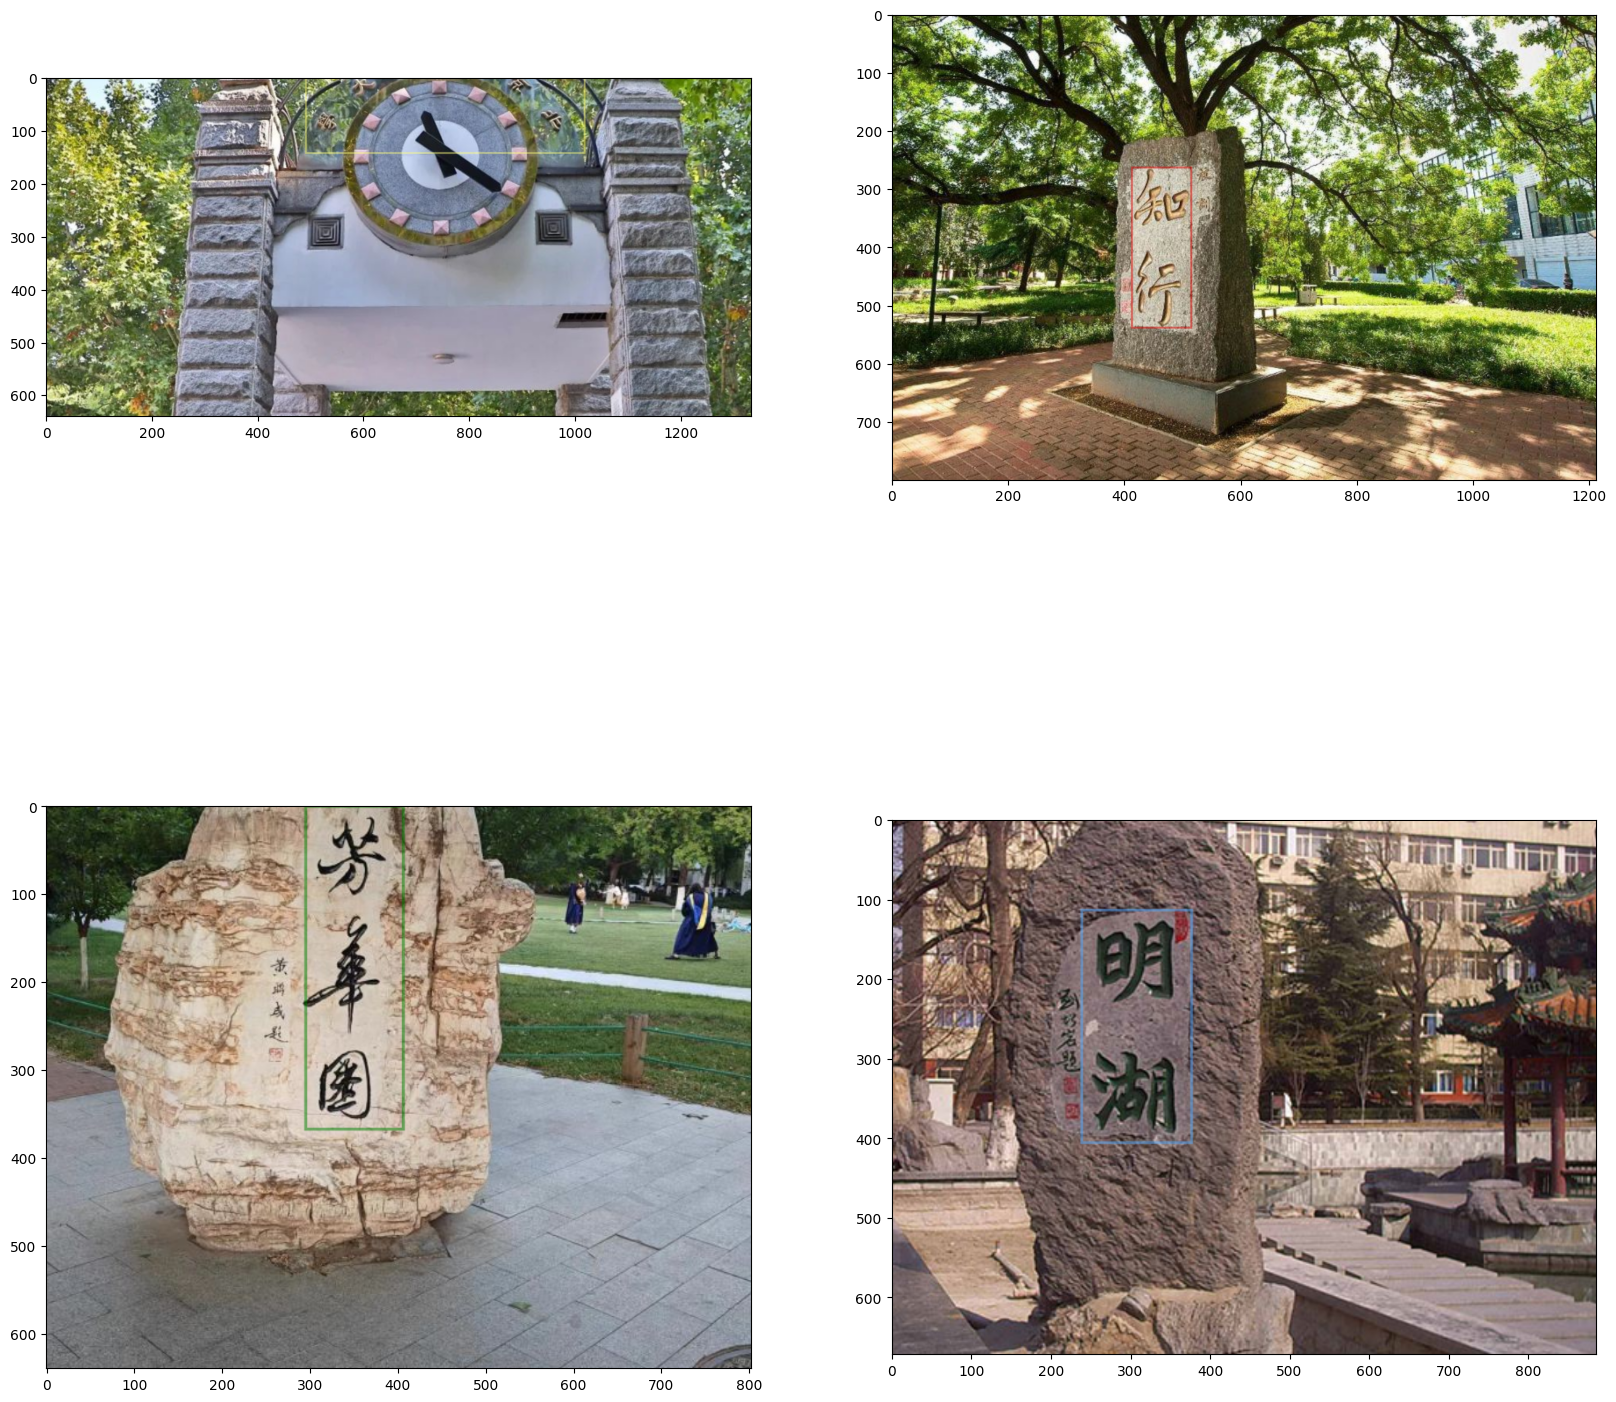

In [19]:

from detectron2.data import detection_utils as utils
def show_sample_from_trainer(cfg, trainer):
    train_data_loader = trainer.build_train_loader(cfg)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    data_iter = iter(train_data_loader)
    batch = next(data_iter)
    rows, cols = 2, 2
    plt.figure(figsize=(20,20))

    for i, per_image in enumerate(batch[:4]):
        
        plt.subplot(rows, cols, i+1)
        
        # Pytorch tensor is in (C, H, W) format
        img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = utils.convert_image_to_rgb(img, "BGR")

        visualizer = Visualizer(img, metadata=metadata, scale=1)

        target_fields = per_image["instances"].get_fields()
        labels = None
        vis = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
            keypoints=target_fields.get("gt_keypoints", None),
        )
        show_img = cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB) 
        
        plt.imshow(show_img)
show_sample_from_trainer(cfg, trainer)

# 训练

In [22]:

trainer.train()

[06/19 00:49:35 d2.engine.train_loop]: Starting training from iteration 0
[06/19 00:49:55 d2.utils.events]:  eta: 0:13:23  iter: 19  total_loss: 1.644  loss_cls: 1.5  loss_box_reg: 0.0498  loss_rpn_cls: 0.08057  loss_rpn_loc: 0.01347    time: 0.9017  last_time: 1.1147  data_time: 0.5325  last_data_time: 0.6974   lr: 0.00024976  max_mem: 20789M
[06/19 00:50:14 d2.utils.events]:  eta: 0:14:05  iter: 39  total_loss: 0.3339  loss_cls: 0.1747  loss_box_reg: 0.08305  loss_rpn_cls: 0.04933  loss_rpn_loc: 0.01173    time: 0.9124  last_time: 1.0219  data_time: 0.4794  last_data_time: 0.5969   lr: 0.00049951  max_mem: 20789M
[06/19 00:50:30 d2.utils.events]:  eta: 0:13:27  iter: 59  total_loss: 0.3613  loss_cls: 0.1793  loss_box_reg: 0.1329  loss_rpn_cls: 0.02234  loss_rpn_loc: 0.01003    time: 0.8822  last_time: 1.1045  data_time: 0.3972  last_data_time: 0.6783   lr: 0.00074926  max_mem: 20789M
[06/19 00:50:52 d2.utils.events]:  eta: 0:13:51  iter: 79  total_loss: 0.3567  loss_cls: 0.174  loss_

# 测试

In [5]:
""" 
Eval
"""

# dataset_dicts = get_bjtu_dicts(PATH_test)
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold


from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


def eval(cfg, dataset, weight_dir=None, score=0.5):
    cfg = cfg.clone()
    if weight_dir is None:
        weight_dir = cfg.OUTPUT_DIR
    cfg.MODEL.WEIGHTS = os.path.join(weight_dir, "model_final.pth")
    predictor = DefaultPredictor(cfg)
    output_dir = os.path.join(weight_dir, "coco_eval")
    os.makedirs(output_dir, exist_ok=True)
    evaluator = COCOEvaluator(dataset, output_dir=output_dir)
    val_loader = build_detection_test_loader(cfg, dataset)
    print(inference_on_dataset(predictor.model, val_loader, evaluator))
    # another equivalent way to evaluate the model is to use `trainer.test`


eval(cfg, "bjtu_test_washed", "result/baseline_faster_r50_b16_s250_washed")

[06/19 01:49:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from result/baseline_faster_r50_b16_s250_washed/model_final.pth ...
WARNING [06/19 01:49:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/19 01:49:08 d2.data.datasets.coco]: Loaded 153 images in COCO format from BJTU_washed/test.json
[06/19 01:49:08 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    BJTU    | 64           |    FHY     | 24           |     MH     | 22           |
|    TSG     | 10           |    TYHT    | 7            |     ZX     | 26           |
|            |              |            |              |            |              |
|   total    | 153          |            |              |            |              |
[06/19 01:4

/mnt/data131/gyk/envs/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/19 01:49:10 d2.evaluation.evaluator]: Inference done 11/153. Dataloading: 0.0023 s/iter. Inference: 0.0441 s/iter. Eval: 0.0002 s/iter. Total: 0.0467 s/iter. ETA=0:00:06
[06/19 01:49:15 d2.evaluation.evaluator]: Inference done 54/153. Dataloading: 0.0672 s/iter. Inference: 0.0420 s/iter. Eval: 0.0002 s/iter. Total: 0.1096 s/iter. ETA=0:00:10
[06/19 01:49:20 d2.evaluation.evaluator]: Inference done 112/153. Dataloading: 0.0544 s/iter. Inference: 0.0425 s/iter. Eval: 0.0002 s/iter. Total: 0.0972 s/iter. ETA=0:00:03
[06/19 01:49:22 d2.evaluation.evaluator]: Total inference time: 0:00:12.453552 (0.084146 s / iter per device, on 1 devices)
[06/19 01:49:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.038690 s / iter per device, on 1 devices)
[06/19 01:49:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 01:49:22 d2.evaluation.coco_evaluation]: Saving results to result/baseline_faster_r50_b16_s250_washed/coco_eval/coco_instances_res

# Check Single

In [8]:
"""
Show single file
"""


def check_single(cfg, dataset, weight_dir=None, score=0.5):
    dataset_dicts = DatasetCatalog.get(dataset)
    cfg = cfg.clone()
    if weight_dir is None:
        weight_dir = cfg.OUTPUT_DIR
    cfg.MODEL.WEIGHTS = os.path.join(weight_dir, "model_final.pth")
    predictor = DefaultPredictor(cfg)
    outputs_list = []
    for d in random.sample(dataset_dicts, 20):
        out_list = []
        print(d)
        im = cv2.imread(d["file_name"])
        outputs = predictor(
            im
        )  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v1 = Visualizer(
            im[:, :, ::-1],
            metadata=MetadataCatalog.get(dataset),
            scale=1,
        )
        out = v1.draw_dataset_dict(d)
        out_list.append(out.get_image()[:, :, ::-1])
        v2 = Visualizer(
            im[:, :, ::-1],
            metadata=MetadataCatalog.get(dataset),
            scale=1,
        )
        out = v2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_list.append(out.get_image()[:, :, ::-1])
        out_list.append(im)
        outputs_list.append(out_list)
    return outputs_list


outputs = check_single(cfg, "bjtu_test_washed", weight_dir="result/hit_faster_r101_b16_s500_washed")

WARNING [06/18 23:55:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 23:55:14 d2.data.datasets.coco]: Loaded 153 images in COCO format from BJTU_washed/test.json
[06/18 23:55:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from result/hit_faster_r101_b16_s500_washed/model_final.pth ...
{'file_name': './BJTU_washed/test/fhy-ashjbfiuoq3ro0.jpg', 'height': 1500, 'width': 2000, 'image_id': 7, 'annotations': [{'iscrowd': 0, 'bbox': [586.0, 569.0, 165.0, 590.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
{'file_name': './BJTU_washed/test/mh-vcbdnfgjihu9m456yr8t7e0w.jpg', 'height': 758, 'width': 1011, 'image_id': 45, 'annotations': [{'iscrowd': 0, 'bbox': [531.0, 305.0, 74.0, 160.0], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
{'file_name': './BJTU_washed/test/zx-0e1c7605e7e76d08e5691e8258a7096.jpg', 'height': 720, 'width': 1080, 'image_id': 139, 'annotations': [{'iscro

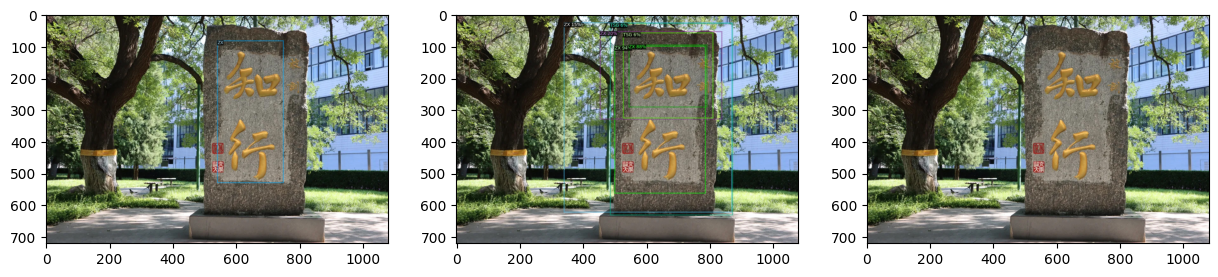

In [9]:
def show_batch(output, index):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        show_img = output[index][i]
        show_img = cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB)
        # ax.axis('off')
        ax.imshow(show_img)
    plt.show()


show_batch(outputs, 2)